Извлекаем и анализируем данные из архива от MiFit


# Входные данные

# Получение архива

Через пару минут, после запроса данных mi fit высылает архив и пароль на указанную почту

TODO: автоматическое получение архива от mi fit по расписанию с отправкой графиков в телеграм через бота?

# Распаковка архива

Очистка папки с данными

In [115]:
!rm -rf /content/dataset

In [ ]:
'''with zipfile.ZipFile(activity_path, mode='r') as zip:
    
    zip.extractall(pwd=bytes(password, 'utf-8'))'''

zipfile и pyzipper не смогли открыть архив. Похоже неподдерживаемый формат шифрования. В коллабе можно воспользоваться волшебной командой, где PASSWORD - пароль от архива, который mi fit присылает в письме:

In [ ]:
!7z e -pgmHNGtWb /content/3005092385_1642776593637.zip  -o/content/dataset

В локальном ноутбуке похоже придётся вызывать консольный 7-Zip с параметрами

Посмотрим какие файлы оказались в архиве. !7Z распаковал архив, вытащив файлы из своих подпапок, наверное, надо что-то другое указывать в "-o", чтобы такого не происходило. Но лучше отфильтруем с помощью isfile

In [125]:
from os import listdir
from os.path import isfile, join
import re

In [133]:
files = [f for f in listdir('dataset') if isfile(join('dataset', f))]
files

['SPORT_1642776593324.csv',
 'BODY_1642776593017.csv',
 'ACTIVITY_MINUTE_1642776591564.csv',
 'ACTIVITY_1642776590857.csv',
 'HEARTRATE_1642776592237.csv',
 'HEARTRATE_AUTO_1642776592508.csv',
 'ACTIVITY_STAGE_1642776591113.csv',
 'USER_1642776590078.csv',
 'SLEEP_1642776592044.csv']

Создадим переменные с названиями файлов

In [137]:
activity_cond = re.compile('ACTIVITY_\d+')
activity_fname = str(list(filter(activity_cond.match, files))[0])

sleep_cond = re.compile('SLEEP_\d+')
sleep_fname = str(list(filter(sleep_cond.match, files))[0])

body_cond = re.compile('BODY_\d+')
body_fname = str(list(filter(body_cond.match, files))[0])

print(activity_fname, sleep_fname, body_fname)

ACTIVITY_1642776590857.csv SLEEP_1642776592044.csv BODY_1642776593017.csv


# Анализ

In [166]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Создадим первую таблицу из файла с общей информацией по активности. Сразу скажем pandas, что в первой колонке у нас datetime64

In [138]:
activity = pd.read_csv ('/content/dataset/' + activity_fname, parse_dates=[0], infer_datetime_format=True )
activity.head(4)  

,date,steps,distance,runDistance,calories
0,2016-07-29,4266,3268,285,203
1,2016-07-30,8088,5637,158,480
2,2016-07-31,4251,2910,49,265
3,2016-08-01,17596,13405,359,874


In [31]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         500 non-null    datetime64[ns]
 1   steps        500 non-null    int64         
 2   distance     500 non-null    int64         
 3   runDistance  500 non-null    int64         
 4   calories     500 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 19.7 KB


Значений Null в нет. Но есть нулевые значения

In [155]:
activity[activity['steps'] == 0].shape

(52, 6)

Создадим столбец с днями недели по которым потом будем группировать

In [178]:
activity['day_of_week'] = activity['date'].dt.dayofweek
activity.head(4)

,date,steps,distance,runDistance,calories,day_of_week
0,2016-07-29,4266,3268,285,203,4
1,2016-07-30,8088,5637,158,480,5
2,2016-07-31,4251,2910,49,265,6
3,2016-08-01,17596,13405,359,874,0


In [ ]:
#activity.style.format({"date": lambda t: t.strftime("%d/%m/%Y")})

Выведем все дни, когда число шагов превышало 8000 (Рекомендации ВОЗ коллеблятся от 7500 до 10000, но мы будем придерживаться цели, поставленной мудрыми китайскими разработчиками по дефолту). Посмотрим рекорд по числу шагов

In [179]:
activity[activity['steps']  > 8000].sort_values(by='steps', ascending=False)

,date,steps,distance,runDistance,calories,day_of_week
276,2017-09-07,25574,20399,3120,859,3
206,2017-06-28,22525,17947,790,715,2
207,2017-06-29,21365,17482,988,745,3
492,2018-04-25,21045,16911,3182,764,2
308,2017-10-09,19609,15305,908,626,0
...,...,...,...,...,...,...
74,2016-10-28,8204,6361,335,250,4
248,2017-08-09,8114,6209,402,229,2
1,2016-07-30,8088,5637,158,480,5
193,2017-06-15,8082,6411,198,254,3


Создадим вторую таблицу со сном и соединим.

In [148]:
sleep = pd.read_csv ('/content/dataset/' + sleep_fname, parse_dates=[0], infer_datetime_format=True )
sleep.head(4)

,date,deepSleepTime,shallowSleepTime,wakeTime,start,stop
0,2016-07-29,0,0,0,2016-07-28 21:00:00+0000,2016-07-28 21:00:00+0000
1,2016-07-30,221,239,0,2016-07-29 22:05:00+0000,2016-07-30 05:45:00+0000
2,2016-07-31,192,414,0,2016-07-30 20:36:00+0000,2016-07-31 06:42:00+0000
3,2016-08-01,121,305,1,2016-07-31 22:00:00+0000,2016-08-01 05:07:00+0000


In [55]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              500 non-null    datetime64[ns]
 1   deepSleepTime     500 non-null    int64         
 2   shallowSleepTime  500 non-null    int64         
 3   wakeTime          500 non-null    int64         
 4   start             500 non-null    object        
 5   stop              500 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 23.6+ KB


Объединим данные из первых двух таблиц по дате.

In [181]:
main_table = pd.merge(activity, sleep, on='date', how='inner')
main_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              500 non-null    datetime64[ns]
 1   steps             500 non-null    int64         
 2   distance          500 non-null    int64         
 3   runDistance       500 non-null    int64         
 4   calories          500 non-null    int64         
 5   day_of_week       500 non-null    int64         
 6   deepSleepTime     500 non-null    int64         
 7   shallowSleepTime  500 non-null    int64         
 8   wakeTime          500 non-null    int64         
 9   start             500 non-null    object        
 10  stop              500 non-null    object        
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 46.9+ KB


In [75]:
main_table['distance'].describe()

count      500.000000
mean      5738.484000
std       4622.430751
min          0.000000
25%       1309.000000
50%       5195.500000
75%       9870.250000
max      20399.000000
Name: distance, dtype: float64

In [158]:
main_table['step_size'] = main_table['distance'] / main_table['steps']
main_table.head(4)

,date,steps,distance,runDistance,calories,day_of_week,deepSleepTime,shallowSleepTime,wakeTime,start,stop,step_size
0,2016-07-29,4266,3268,285,203,Friday,0,0,0,2016-07-28 21:00:00+0000,2016-07-28 21:00:00+0000,0.766057
1,2016-07-30,8088,5637,158,480,Saturday,221,239,0,2016-07-29 22:05:00+0000,2016-07-30 05:45:00+0000,0.696958
2,2016-07-31,4251,2910,49,265,Sunday,192,414,0,2016-07-30 20:36:00+0000,2016-07-31 06:42:00+0000,0.684545
3,2016-08-01,17596,13405,359,874,Monday,121,305,1,2016-07-31 22:00:00+0000,2016-08-01 05:07:00+0000,0.761821


In [159]:
main_table.groupby('day_of_week')[['steps', 'distance', 'calories', 'step_size']].mean()

,steps,distance,calories,step_size
day_of_week,,,,
Friday,8467.164384,6647.520548,289.547945,0.769259
Monday,9367.014286,7265.557143,315.114286,0.764266
Saturday,5296.013699,4070.767123,185.410959,0.744420
Sunday,3295.541667,2471.263889,106.819444,0.720637
Thursday,8251.971831,6491.492958,284.647887,0.772369
Tuesday,8045.070423,6277.366197,274.943662,0.769347
Wednesday,8998.671429,7052.828571,302.114286,0.771771


Странно, что длина шага получилось разной. Был уверен, что она высчитывается из роста по формуле. 


Построим матрицу корреляций. Расстояние и шаги коррелируют с числом сожжёных каллорий, их частное (длина шага) соответственно тоже.

In [170]:
corr = main_table[['steps', 'distance', 'calories', 'step_size', 'deepSleepTime',	'shallowSleepTime']].corr()
corr

,steps,distance,calories,step_size,deepSleepTime,shallowSleepTime
steps,1.000000,0.999425,0.967300,0.779204,0.115448,0.110203
distance,0.999425,1.000000,0.966412,0.787196,0.108020,0.102942
calories,0.967300,0.966412,1.000000,0.760746,0.137204,0.122642
step_size,0.779204,0.787196,0.760746,1.000000,-0.119523,-0.153258
deepSleepTime,0.115448,0.108020,0.137204,-0.119523,1.000000,0.816068
shallowSleepTime,0.110203,0.102942,0.122642,-0.153258,0.816068,1.000000


Надо больше гулять на выходных

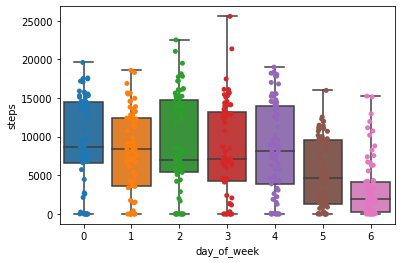

In [187]:
ax = sns.stripplot(x='day_of_week', y='steps', data=main_table)
ax = sns.boxplot(x='day_of_week', y='steps', data=main_table, whis=np.inf)

In [190]:
'''body = pd.read_csv ('/content/dataset/' + body_fname, parse_dates=[0], infer_datetime_format=True )
body['date'] = pd.to_datetime(body['time'].dt.date)
body.head(5)'''

,time,weight,height,bmi,fatRate,bodyWaterRate,boneMass,metabolism,muscleRate,visceralFat,date
0,2020-07-06 03:13:52,48.0,162.0,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-06
1,2020-07-05 19:30:23,48.4,162.0,18.4,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-05
2,2020-07-03 05:41:26,47.9,162.0,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-03
3,2020-07-01 10:58:25,47.8,162.0,18.2,21.0,54.1,1.9,990.0,35.7,2.0,2020-07-01
4,2020-07-01 10:57:53,47.8,162.0,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-01
